In [21]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck

def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [2]:
df = pd.read_csv('/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/drosophila_gene2go.csv', delim_whitespace=True)

df['val'] = 1

go_table = pd.pivot_table(df, index=['NetworkIDs'], values=['val'],columns=['GO_term'])

go_table = go_table.fillna(0)

from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
exp_file_path = "/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/drosophila_dist.h5" 
exp_file = hm.hiCMatrix(exp_file_path)

exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
exp_matrix = exp_file.matrix.toarray()
np.fill_diagonal(exp_matrix , 1)
df_exp = pd.DataFrame(exp_matrix ,  index=exp_genes_all , columns = exp_genes_all )


df_2d = run_egad(go_table, df_exp)

df_2d.to_csv('./del.csv', sep='\t')

In [27]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
exp_file_path = "/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/drosophila_dist.h5" 
exp_file = hm.hiCMatrix(exp_file_path)

In [31]:
exp_file.matrix.toarray().sum(axis=0)

array([7.23276279e+10, 7.16760457e+10, 7.03841510e+10, ...,
       6.80401200e+07, 7.14493540e+07, 7.14627610e+07])

In [32]:
exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]

In [33]:
data_tuples = list(zip([x[3].decode() for x in exp_file.cut_intervals],exp_file.matrix.toarray().sum(axis=0)))
pd.DataFrame(data_tuples, columns=['genes','degree'])

genes        degree
0      FBgn0267431  7.232763e+10
1      FBgn0085804  7.167605e+10
2      FBgn0039987  7.038415e+10
3      FBgn0267798  6.898037e+10
4      FBgn0267797  6.689135e+10
...            ...           ...
14871  FBgn0250819  6.668846e+07
14872  FBgn0039924  6.782980e+07
14873  FBgn0263112  6.804012e+07
14874  FBgn0027101  7.144935e+07
14875  FBgn0053653  7.146276e+07

[14876 rows x 2 columns]

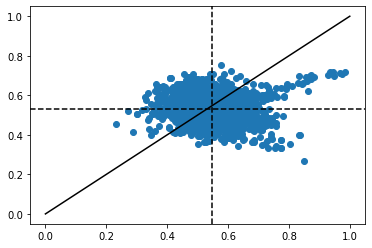

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(df_2d['AUC'], df_2d['DEGREE_NULL_AUC'], 'o')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')